In [269]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matrixprofile as mp
from matrixprofile import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os

import warnings
warnings.filterwarnings('ignore')

# Data Load

In [6]:
# reading the dataset
phaseI_data_path = "../data/Phase"

anomaly_file_1, anomaly_file_2 = set([204, 205]), set([206, 207, 208, 242, 243, 225, 226])
total_df, train_df, test_df = list(), list(), list()
idx = 1
for filename in os.listdir(phaseI_data_path):
    df = pd.read_csv(phaseI_data_path + '/' + filename, names=['values'])
    if idx in anomaly_file_1:
        newDf = pd.DataFrame()
        newDf['values'] = list(map(float, list(df.iloc[0])[0].strip(' ').split('   ')))
        df = newDf
    elif idx in anomaly_file_2:
        newDf = pd.DataFrame()
        newDf['values'] = list(map(float, list(df.iloc[0])[0].strip(' ').split('  ')))
        df = newDf
    total_df.append(df)
    partition = int(filename.split('_')[-1].split('.')[0])
    train_df.append(df.iloc[: partition])
    test_df.append(df.iloc[partition: ])
    idx += 1

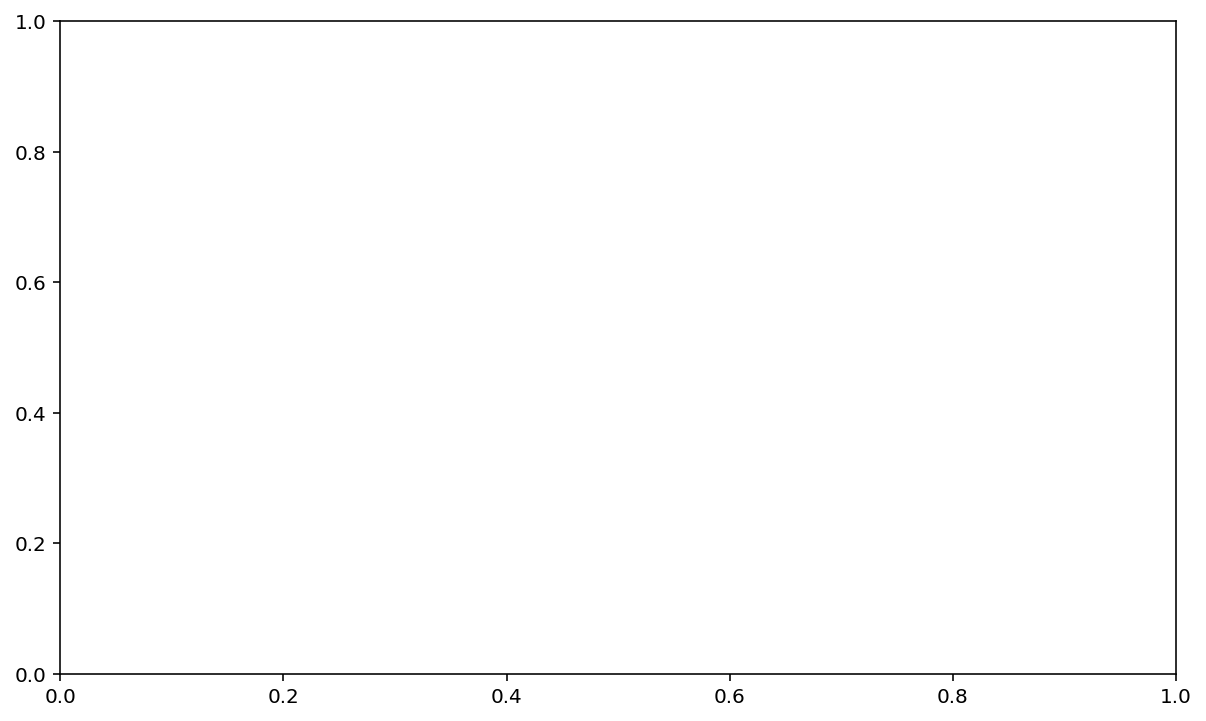

In [161]:
# show data
select = 0
train_select = train_df[select]
test_select = test_df[select]
train_select['c'] = 0
test_select['c'] = 1

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(train_select['values'], color='b')
plt.plot(test_select['values'], color='r')
plt.title(str(select) + 'th data')
# plt.savefig(f'images/origin_data/{select}', dpi=220, bbox_inches='tight')
plt.show()

## Average Smoothing

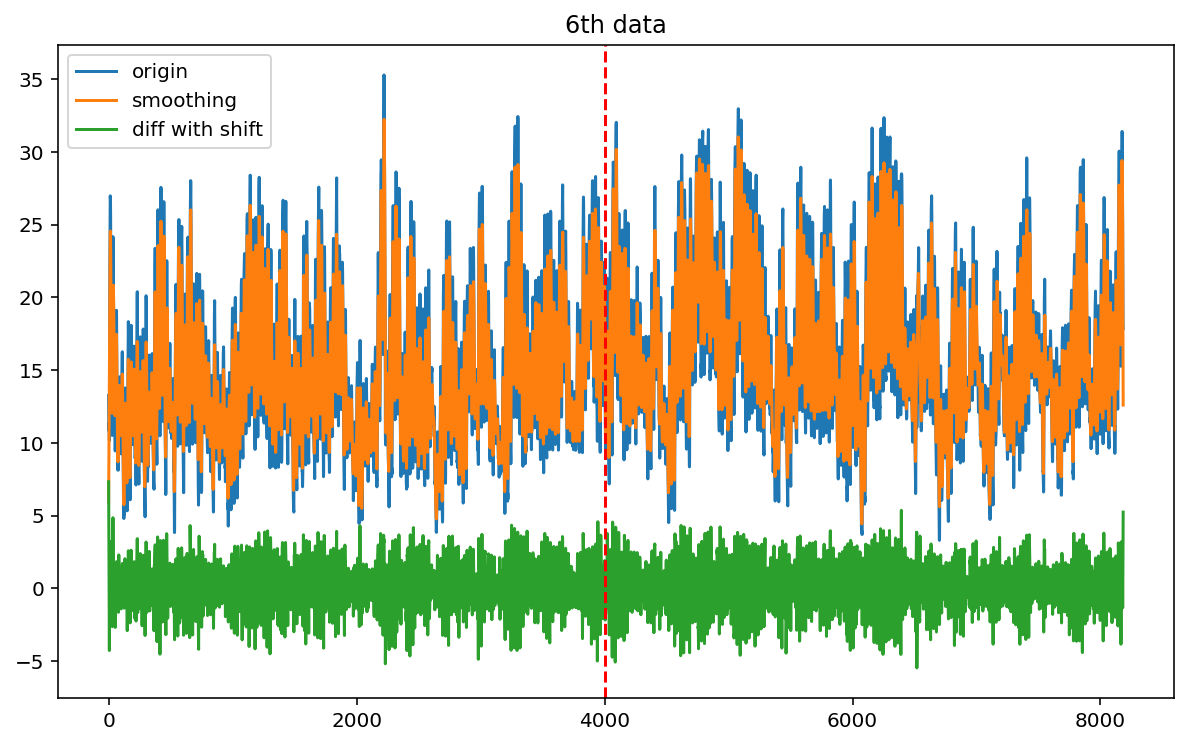

In [149]:
select = 6
train_test_select = total_df[select]

x = np.array(train_test_select['values'])
weight = np.ones(10) / 10
result = np.convolve(x, weight, mode='same')

plt.title(str(select) + 'th data')
plt.plot(np.arange(x.shape[0]), x, label = 'origin')
plt.plot(np.arange(x.shape[0]), result, label = 'smoothing')
plt.plot(np.arange(x.shape[0]), x - result, label = 'diff with shift')
plt.axvline(train_df[select].shape[0], color='r', linestyle='dashed')
plt.legend()
plt.savefig(f'images/average_smoothing/{select}', dpi=220, bbox_inches='tight')
plt.show()

## EMD

In [85]:
from PyEMD import EMD

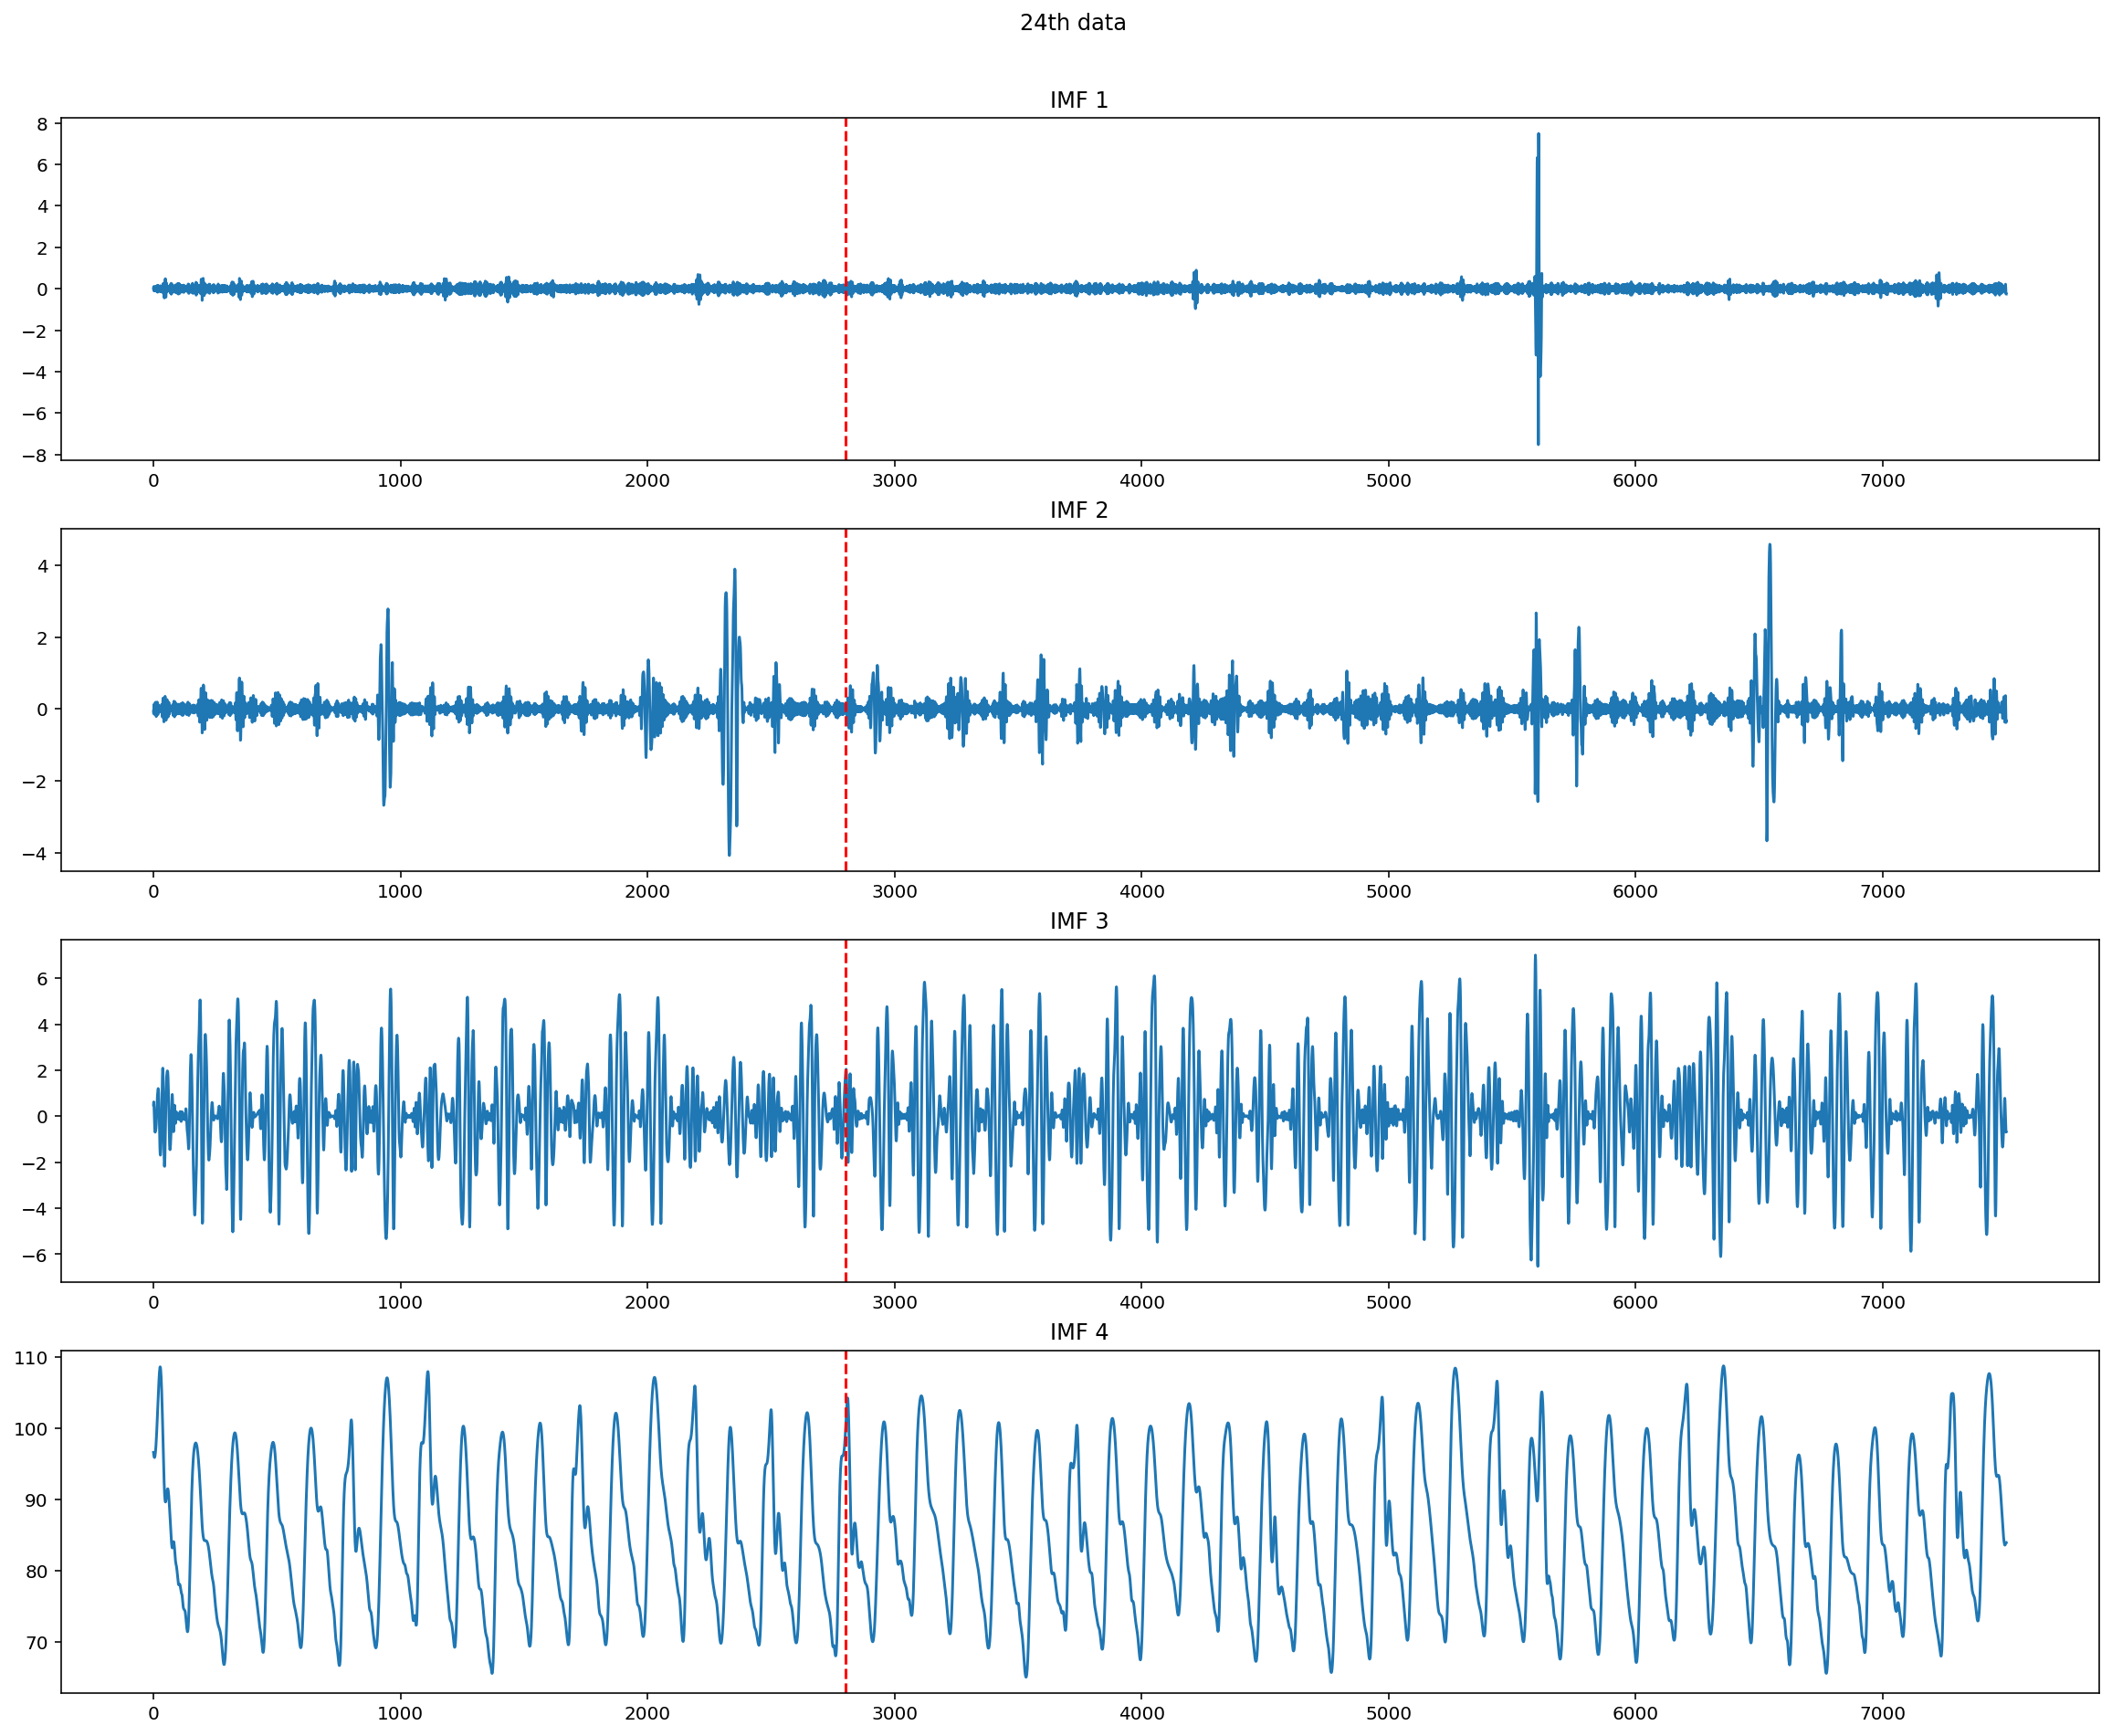

In [160]:
select = 24
train_test_select = total_df[select]

x = np.array(train_test_select['values'])

emd = EMD()
IMFs = emd(x, max_imf=3)


plt.rcParams['figure.figsize'] = (20, 20)
plt.suptitle(f'{select}th data', x = 0.51, y = 0.92)
for n, imf in enumerate(IMFs):
    plt.subplot(IMFs.shape[0] + 1, 1, n + 1)
    plt.plot(np.arange(x.shape[0]), imf)
    plt.axvline(train_df[select].shape[0], color='r', linestyle='dashed')
    plt.title("IMF " + str(n + 1))


plt.savefig(f'images/emd/{select}', dpi=220, bbox_inches='tight')
plt.rcParams['figure.figsize'] = (10, 6)

## SR

In [162]:
import sranodec as anom

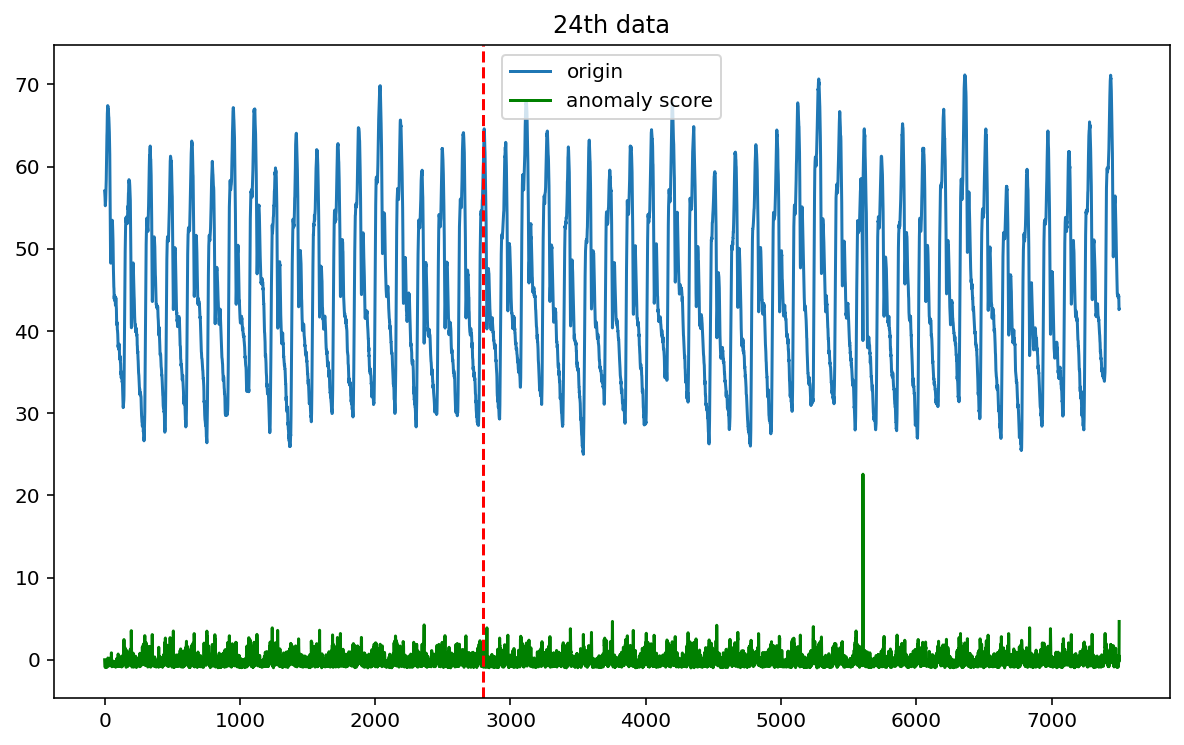

In [199]:
select = 24
train_test_select = total_df[select]
# sc = StandardScaler()
x = np.array(train_test_select['values'])
# x = sc.fit_transform(x.reshape(-1, 1))

# less than period
amp_window_size=24
# (maybe) as same as period
series_window_size=24
# a number enough larger than period
score_window_size=100

spec = anom.Silency(amp_window_size, series_window_size, score_window_size)
score = spec.generate_anomaly_score(x)

plt.plot(np.arange(x.shape[0]), x - 40, label = 'origin')
plt.plot(score, color='g', label='anomaly score')
plt.axvline(train_df[select].shape[0], color='r', linestyle='dashed')
plt.title(f'{select}th data')
plt.legend()
plt.savefig(f'images/SR/{select}', dpi=220, bbox_inches='tight')
plt.show()

## RRCF

In [214]:
import rrcf

In [215]:
class RRCF:
    def __init__(self, 
                 nums_trees, 
                 shingle_size, 
                 tree_size
                ):
        """
        initialize RRCF model based on rrcf
        """
        self.num_trees = nums_trees
        self.shingle_size = shingle_size
        self.tree_size = tree_size
        self.forest = []
        # self.clf = LogisticRegression(class_weight={0: 1, 1: 1e9})
        self.p = 0
        self.index = 0

    def train(self, 
              X, 
              y=None):
        # Use the "shingle" generator to create rolling window
        points = rrcf.shingle(X, size=self.shingle_size)
        points = np.vstack([point for point in points])
        n = points.shape[0]
        sample_size_range = (n // self.tree_size, self.tree_size)
        
        if n // self.tree_size == 0:
            print("Error! smaple size range is 0!")
        
        # build forest
        self.forest = []
        while len(self.forest) < self.num_trees:
            ixs = np.random.choice(n, size=sample_size_range,
                                   replace=False)
            trees = [rrcf.RCTree(points[ix], index_labels=ix) for ix in ixs]
            self.forest.extend(trees)
        
        # calculate codisp
        avg_codisp = pd.Series(0.0, index=np.arange(n))
        index = np.zeros(n)

        for tree in self.forest:
            codisp = pd.Series({leaf : tree.codisp(leaf)
                                for leaf in tree.leaves})
            avg_codisp[codisp.index] += codisp
            np.add.at(index, codisp.index.values, 1)

        avg_codisp /= index
        avg_codisp.index = X.iloc[(self.shingle_size - 1):].index
        avg_codisp = np.array([0] * (self.shingle_size - 1) + list(avg_codisp))
        
        # LR model
        # self.clf.fit(avg_codisp.reshape(-1, 1), y)
        p_0 = avg_codisp[np.where(y==0)]
        p_1 = avg_codisp[np.where(y==1)]
        if len(p_1) != 0:
            self.p = 0.6 * (p_0.mean() + p_1.mean())
        else:
            self.p = p_0.mean() + 9 * p_0.std()
        
    def predict(self, 
                X):
        # X = np.array(X)
        
        # Use the "shingle" generator to create rolling window
        points = rrcf.shingle(X, size=self.shingle_size)
        points = np.vstack([point for point in points])
        n = points.shape[0]
        sample_size_range = (n // self.tree_size, self.tree_size)
        
        if n // self.tree_size == 0:
            print("Error! smaple size range is 0!")
        
        # build forest
        self.forest = []
        while len(self.forest) < self.num_trees:
            ixs = np.random.choice(n, size=sample_size_range,
                                   replace=False)
            trees = [rrcf.RCTree(points[ix], index_labels=ix) for ix in ixs]
            self.forest.extend(trees)
        
        # calculate codisp
        avg_codisp = pd.Series(0.0, index=np.arange(n))
        index = np.zeros(n)

        for tree in self.forest:
            codisp = pd.Series({leaf : tree.codisp(leaf)
                                for leaf in tree.leaves})
            avg_codisp[codisp.index] += codisp
            np.add.at(index, codisp.index.values, 1)

        avg_codisp /= index
        avg_codisp.index = X.iloc[(self.shingle_size - 1):].index
        avg_codisp = np.array([0] * (self.shingle_size - 1) + list(avg_codisp))
        
        
        # return self.clf.predict_proba(X.reshape(-1, 1))
        return [0 if avg_codisp[index] <= self.p else 1 for index in range(len(avg_codisp))]
    
    def predict_proba(self,
                     X):
        
        # Use the "shingle" generator to create rolling window
        points = rrcf.shingle(X, size=self.shingle_size)
        points = np.vstack([point for point in points])
        n = points.shape[0]
        sample_size_range = (n // self.tree_size, self.tree_size)
        
        if n // self.tree_size == 0:
            print("Error! smaple size range is 0!")
        
        # build forest
        self.forest = []
        while len(self.forest) < self.num_trees:
            ixs = np.random.choice(n, size=sample_size_range,
                                   replace=False)
            trees = [rrcf.RCTree(points[ix], index_labels=ix) for ix in ixs]
            self.forest.extend(trees)
        
        # calculate codisp
        avg_codisp = pd.Series(0.0, index=np.arange(n))
        index = np.zeros(n)

        for tree in self.forest:
            codisp = pd.Series({leaf : tree.codisp(leaf)
                                for leaf in tree.leaves})
            avg_codisp[codisp.index] += codisp
            np.add.at(index, codisp.index.values, 1)

        avg_codisp /= index
        avg_codisp.index = X.iloc[(self.shingle_size - 1):].index
        avg_codisp = np.array([0] * (self.shingle_size - 1) + list(avg_codisp))
        
        
        # return self.clf.predict_proba(X.reshape(-1, 1))
        return np.array(avg_codisp)

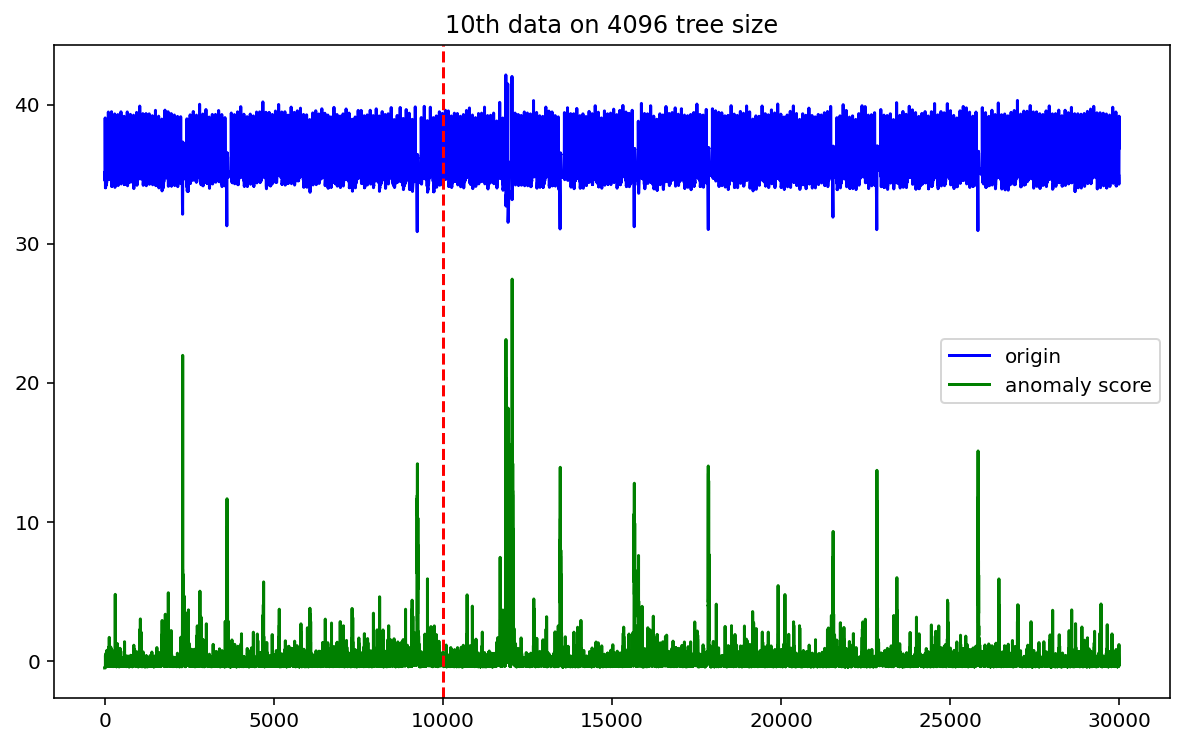

In [286]:
select = 10
train_test_select = total_df[select]
sc = StandardScaler()
x = np.array(train_test_select['values'])
x_scaled = sc.fit_transform(x.reshape(-1, 1))

model = RRCF(100, 24, 4096) # half-period window is better
codisp = model.predict_proba(pd.Series(x))


codisp = sc.fit_transform(codisp.reshape(-1, 1))

plt.rcParams['figure.figsize'] = (10, 6)
plt.plot(np.arange(x.shape[0]), x_scaled + 35, color='b', label = 'origin')
plt.plot(np.arange(x.shape[0]), codisp, color='g', label='anomaly score')
plt.axvline(train_df[select].shape[0], color='r', linestyle='dashed')
plt.title(f'{select}th data on 4096 tree size')
plt.legend()
plt.savefig(f'images/RRCF/{select} on 4096 tree size', dpi=220, bbox_inches='tight')
plt.show()

## AE && VAE

In [314]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


torch.set_default_tensor_type(torch.FloatTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [315]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta

        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f"Validation loss decresed ({self.val_loss_min:.6f} --> {val_loss:.6f}. Saving model ...")
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss

In [308]:
class AE(nn.Module):
    def __init__(self, window_size: int):
        super(AE, self).__init__()
        self.window_size = window_size
        self.encoder = nn.Sequential(
            nn.Linear(self.window_size, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, self.window_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        inputs = x
        inputs = self.encoder(inputs)
        inputs = self.decoder(inputs)
        return inputs
    

def normalization(x):
    return (x - x.min()) / (x.max() - x.min())

def shingle(sequence: np.ndarray, window_size: int) -> np.ndarray:
    X = []
    for i in range(len(sequence) - window_size):
        X.append(sequence[i: i + window_size])
    return np.array(X)


def reconstruct(length: int, window_size: int, inputs: np.ndarray, model: nn.Module) -> np.ndarray:
    i = 0
    reconstruct_X = np.zeros(shape=length)
    cnt = np.zeros(shape=length)
    inputs = torch.from_numpy(inputs.astype(np.float32)).to(device)
    while i < len(inputs):
        pred = model(inputs[i]).detach().cpu().numpy()
        reconstruct_X[i: i + window_size] += pred
        cnt[i: i + window_size] += 1
        i += window_size // 10
    return reconstruct_X / cnt

In [413]:
select = 113
# timeseries window size
window_size = 64

# train valid data split
total = np.array(total_df[select]['values'])
total = normalization(total)
total_X = shingle(total, window_size)

In [386]:
# with validation

# in AE, train data can overlap with valid data, because object is to fit data itself
train_idx = np.random.choice(np.arange(total_X.shape[0]), size = int(0.8 * total_X.shape[0]), replace=False)
train_X = total_X[train_idx]

valid_idx = np.random.choice(np.arange(total_X.shape[0]), size = int(0.2 * total_X.shape[0]), replace=False)
valid_X = total_X[valid_idx]


# train_X = total_X[: train_df[select].shape[0]]
# valid_X = total_X[train_df[select].shape[0]: ]
num_epochs = 5000
learning_rate = 0.001

train_dataset = TensorDataset(torch.from_numpy(train_X))
train_dataloader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=8)

valid_dataset = TensorDataset(torch.from_numpy(valid_X))
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=True, num_workers=8)

model = AE(window_size).to(device)
criterion = nn.MSELoss() # Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=50, verbose=True)

for epoch in range(num_epochs):
    # train process
    model.train()
    inputs = torch.from_numpy(train_X.astype(np.float32)).to(device)
    targets = torch.from_numpy(train_X.astype(np.float32)).to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    train_loss = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # valid process
    model.eval()
    inputs = torch.from_numpy(valid_X.astype(np.float32)).to(device)
    targets = torch.from_numpy(valid_X.astype(np.float32)).to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    valid_loss = loss.item()
    print("\tepoch: {0} | train loss: {1:.7f} | valid loss: {1:.7f}".format(epoch + 1, train_loss, valid_loss))

    early_stopping(valid_loss, model, "./AE")
    if early_stopping.early_stop:
        print("Early stopping")
        break

	epoch: 1 | train loss: 0.0234445 | valid loss: 0.0234445
Validation loss decresed (inf --> 0.022089. Saving model ...
	epoch: 2 | train loss: 0.0222498 | valid loss: 0.0222498
Validation loss decresed (0.022089 --> 0.020813. Saving model ...
	epoch: 3 | train loss: 0.0209697 | valid loss: 0.0209697
Validation loss decresed (0.020813 --> 0.019149. Saving model ...
	epoch: 4 | train loss: 0.0193011 | valid loss: 0.0193011
Validation loss decresed (0.019149 --> 0.016861. Saving model ...
	epoch: 5 | train loss: 0.0170053 | valid loss: 0.0170053
Validation loss decresed (0.016861 --> 0.013747. Saving model ...
	epoch: 6 | train loss: 0.0138806 | valid loss: 0.0138806
Validation loss decresed (0.013747 --> 0.009728. Saving model ...
	epoch: 7 | train loss: 0.0098444 | valid loss: 0.0098444
Validation loss decresed (0.009728 --> 0.005290. Saving model ...
	epoch: 8 | train loss: 0.0053795 | valid loss: 0.0053795
Validation loss decresed (0.005290 --> 0.002639. Saving model ...
	epoch: 9 | t

	epoch: 85 | train loss: 0.0022071 | valid loss: 0.0022071
Validation loss decresed (0.002156 --> 0.002156. Saving model ...
	epoch: 86 | train loss: 0.0022067 | valid loss: 0.0022067
Validation loss decresed (0.002156 --> 0.002156. Saving model ...
	epoch: 87 | train loss: 0.0022065 | valid loss: 0.0022065
Validation loss decresed (0.002156 --> 0.002156. Saving model ...
	epoch: 88 | train loss: 0.0022066 | valid loss: 0.0022066
Validation loss decresed (0.002156 --> 0.002156. Saving model ...
	epoch: 89 | train loss: 0.0022067 | valid loss: 0.0022067
Validation loss decresed (0.002156 --> 0.002155. Saving model ...
	epoch: 90 | train loss: 0.0022066 | valid loss: 0.0022066
Validation loss decresed (0.002155 --> 0.002155. Saving model ...
	epoch: 91 | train loss: 0.0022063 | valid loss: 0.0022063
Validation loss decresed (0.002155 --> 0.002155. Saving model ...
	epoch: 92 | train loss: 0.0022060 | valid loss: 0.0022060
EarlyStopping counter: 1 out of 50
	epoch: 93 | train loss: 0.0022

	epoch: 160 | train loss: 0.0021066 | valid loss: 0.0021066
EarlyStopping counter: 12 out of 50
	epoch: 161 | train loss: 0.0021151 | valid loss: 0.0021151
EarlyStopping counter: 13 out of 50
	epoch: 162 | train loss: 0.0020955 | valid loss: 0.0020955
EarlyStopping counter: 14 out of 50
	epoch: 163 | train loss: 0.0021031 | valid loss: 0.0021031
Validation loss decresed (0.002036 --> 0.002034. Saving model ...
	epoch: 164 | train loss: 0.0020865 | valid loss: 0.0020865
EarlyStopping counter: 1 out of 50
	epoch: 165 | train loss: 0.0021036 | valid loss: 0.0021036
Validation loss decresed (0.002034 --> 0.002015. Saving model ...
	epoch: 166 | train loss: 0.0020657 | valid loss: 0.0020657
EarlyStopping counter: 1 out of 50
	epoch: 167 | train loss: 0.0020865 | valid loss: 0.0020865
EarlyStopping counter: 2 out of 50
	epoch: 168 | train loss: 0.0020788 | valid loss: 0.0020788
Validation loss decresed (0.002015 --> 0.001998. Saving model ...
	epoch: 169 | train loss: 0.0020487 | valid loss:

In [414]:
# without validation
num_epochs = 5000
learning_rate = 0.001

model = AE(window_size).to(device)
criterion = nn.MSELoss() # Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    model.train()
    inputs = torch.from_numpy(total_X.astype(np.float32)).to(device)
    targets = torch.from_numpy(total_X.astype(np.float32)).to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        print("\tepoch: {0} | loss: {1:.7f}".format(epoch + 1, loss.item()))
    if loss.item() < 0.0002:
        break

	epoch: 50 | loss: 0.0247162
	epoch: 100 | loss: 0.0221840
	epoch: 150 | loss: 0.0224824
	epoch: 200 | loss: 0.0145786
	epoch: 250 | loss: 0.0142729
	epoch: 300 | loss: 0.0127816
	epoch: 350 | loss: 0.0046883
	epoch: 400 | loss: 0.0042304
	epoch: 450 | loss: 0.0036517
	epoch: 500 | loss: 0.0030998
	epoch: 550 | loss: 0.0026632
	epoch: 600 | loss: 0.0021340
	epoch: 650 | loss: 0.0020793
	epoch: 700 | loss: 0.0019164
	epoch: 750 | loss: 0.0019401
	epoch: 800 | loss: 0.0018430
	epoch: 850 | loss: 0.0017808
	epoch: 900 | loss: 0.0017573
	epoch: 950 | loss: 0.0017774
	epoch: 1000 | loss: 0.0017417
	epoch: 1050 | loss: 0.0016958
	epoch: 1100 | loss: 0.0016741
	epoch: 1150 | loss: 0.0016536
	epoch: 1200 | loss: 0.0016155
	epoch: 1250 | loss: 0.0015980
	epoch: 1300 | loss: 0.0013021
	epoch: 1350 | loss: 0.0012749
	epoch: 1400 | loss: 0.0012113
	epoch: 1450 | loss: 0.0011853
	epoch: 1500 | loss: 0.0011684
	epoch: 1550 | loss: 0.0011309
	epoch: 1600 | loss: 0.0011176
	epoch: 1650 | loss: 0.00109

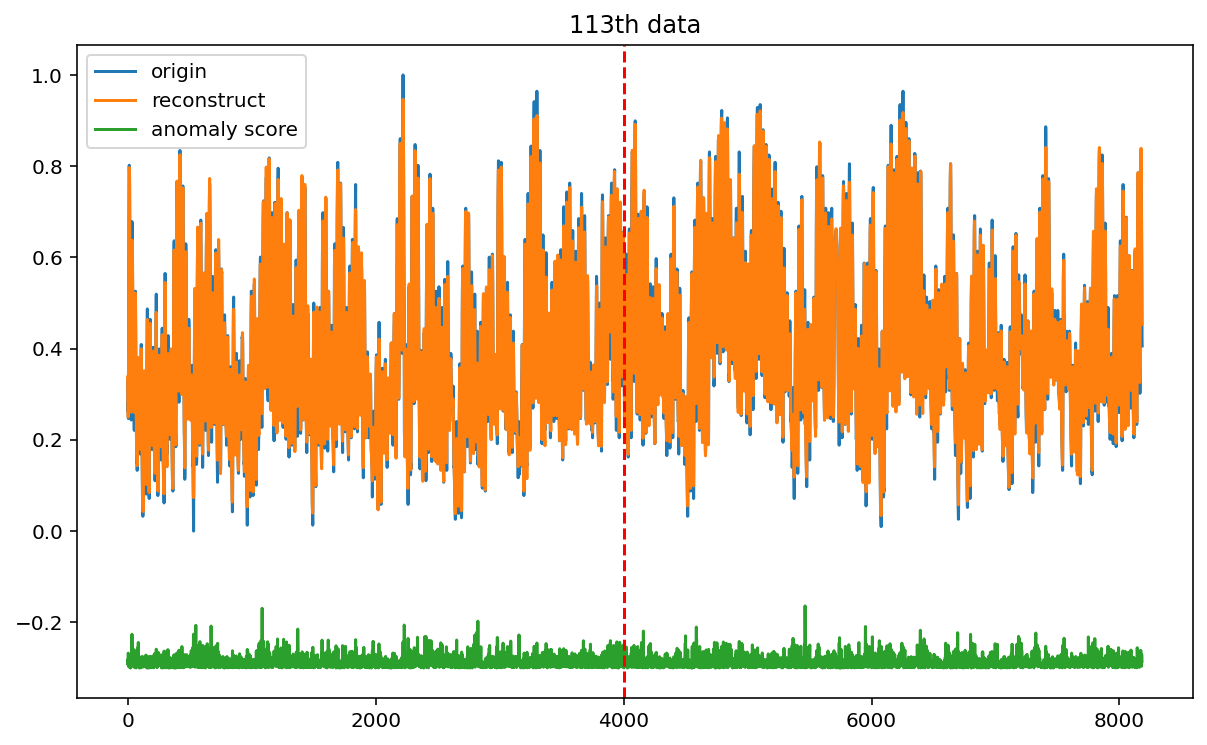

In [415]:
reconstruct_X = reconstruct(len(total), window_size, total_X, model)

plt.title(str(select) + 'th data')

plt.plot(np.arange(len(total)), total, label = 'origin')
plt.plot(np.arange(len(reconstruct_X)), reconstruct_X, label = 'reconstruct')
plt.plot(np.arange(len(reconstruct_X)), abs(total - reconstruct_X) - 0.3, label = 'anomaly score')
plt.axvline(train_df[select].shape[0], color='r', linestyle='dashed')

plt.legend()
plt.savefig(f'images/AE/{select}', dpi=220, bbox_inches='tight')
plt.show()

In [416]:
def loss_funtion(recon_x: torch.Tensor, 
                x: torch.Tensor, 
                mu: torch.Tensor,
                logvar: torch.Tensor):
    # BCE to represent the reconstruction loss between recon_x and x -> Encoder error
    # set size_average to calculate total sum loss
    # TODO: try MSE and size_average=True
    # MSE: bad! size_average=True: bad!
    
    bce_loss = nn.BCELoss(size_average=False)
    BCE = bce_loss(recon_x, x)
    
    # KL Divergence to represent loss between distribution P and Q -> Decoder error
    # use logvar: latent log variance
    KLD_element = - 0.5 * (1 + logvar - mu.pow(2) - logvar.exp_())
    KLD = torch.sum(KLD_element)
    
    return BCE + KLD


class VAE(nn.Module):
    def __init__(self, input_size: int, latent_size: int = 20):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc31 = nn.Linear(256, latent_size)
        self.fc32 = nn.Linear(256, latent_size)
        
        self.fc4 = nn.Linear(latent_size, 256)
        self.fc5 = nn.Linear(256, 512)
        self.fc6 = nn.Linear(512, input_size)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)
    
    def decode(self, z):
        h4 = F.relu(self.fc4(z))
        h5 = F.relu(self.fc5(h4))
        return F.sigmoid(self.fc6(h5))
    
    def reparametrize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)  # return tensor with same size as input filled with N(0, 1)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar